#### Instalación e importación de librerías 

In [1]:
# Instalación de dependencias
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\babv2\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator
from typing import cast, List, Tuple, Optional

import xgboost as xgb

---
---
# Datos

Primero que nada, realicé una pequeña investigación para conocer las variables con las que trabajaré, este es el resumen de las variables:

* `ID`: Identificador único de la observación o del objeto.
* `objID`: Identificador global dentro de la base de datos SDSS (único por objeto).
* `mjd`: Modified Julian Date, fecha de la observación en formato astronómico.
* `mode`: Modo del objeto (p. ej. 1 = primario, 2 = secundario). Indica la prioridad o cómo fue observado.
* `nChild`: Número de objetos “hijos” si el objeto fue dividido en varios durante la segmentación de imagen (por ejemplo, una galaxia separada en subcomponentes).
* `z`: Redshift espectroscópico => mide cuánto se ha desplazado la luz hacia el rojo, relacionado con la distancia o velocidad de recesión.
* `zErr`: Error asociado a la medición de z.
* `zWarning`: Indicador de calidad de la medición del z (0 = confiable, otros valores = advertencias)
* `cx`, `cy`, `cz`: Coordenadas cartesianas unitarias del objeto en el sistema de referencia del SDSS (dirección en el cielo, derivada de RA y Dec).
* `sciencePrimary`: Indica si el objeto es la observación principal usada para análisis científicos (1 = sí).
* `legacyPrimary`, `seguePrimary`, `segue1Primary`, `segue2Primary`, `bossPrimary`, `sdssPrimary`: Flags que indican si el objeto pertenece a distintas campañas del SDSS (Legacy, SEGUE, BOSS, etc.). Útiles para filtrar duplicados.
* `psfMag_*`: Magnitud obtenida ajustando el perfil de una Point Spread Function (PSF), útil para objetos puntuales (como estrellas).
* `fiberMag_*`: Magnitud dentro de la fibra espectroscópica (diámetro fijo), representa el flujo en la región central del objeto.
* `petroMag_*`: Magnitud Petrosian, diseñada para medir de forma consistente el flujo total de galaxias.
* `modelMag_*`: Magnitud derivada del mejor ajuste entre un modelo de Vaucouleurs o exponencial al perfil de la galaxia.
* `cModelMag_*`: Combinación ponderada entre los modelos de Vaucouleurs y exponencial — mejor aproximación al flujo total.
> Nota: Cada grupo tiene su correspondiente error:
> * _Err_u/g/r/i/z: error fotométrico asociado a cada magnitud.
* `calibStatus_u/g/r/i/z`: Estado de la calibración fotométrica para cada banda.
* `extinction_u/g/r/i/z`: Corrección por extinción atmosférica/interstelar (cuánto se atenúa la luz).
* `dered_u/g/r/i/z`: El brillo “real” tras eliminar el efecto del polvo interestelar.
* `mRrCc_r`: Segundo momento del perfil de luz en la banda r (relacionado con la forma y tamaño de la galaxia).
* `mRrCcErr_r`: Error asociado al valor anterior.
* `score`: Valor de calidad, probabilidad, o “confianza” (puede venir de un clasificador anterior o del pipeline del SDSS).
* `resolveStatus`: Estado de resolución del objeto (indica cómo fue tratado si había solapamiento o duplicados).
* `p_cs`: Probabilidad de que el objeto sea compacto o estelar (cs = compact source).
* `p_el`: Probabilidad de que el objeto sea elíptico.
* `label`: Clase final: puede ser Espiral, Elíptica o Irregular.
---

## Exploración Visual
En esta sección se muestran gráficos clave para entender la distribución de clases y patrones fotométricos (colores, magnitudes y `z`). 
> Nota: Se eliminan filas con `label == 3`.

#### Preparación
Leemos y configuramos ajustes generales de las gráficas

In [3]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11
df = pd.read_csv("data/GZ_mini_challenge_train.csv")
df = df[df['label'] != 3].copy()
df['label'] = df['label'].astype(int)

df.head(3)

,ID,mjd,z,zErr,zWarning,cx,cy,cz,sciencePrimary,legacyPrimary,...,extinction_i,extinction_z,dered_u,dered_g,dered_r,dered_i,dered_z,p_cs,p_el,label
0,1,53119,0.142862,0.000031,0,-0.947156,0.234806,0.218546,1,1,...,0.027516,0.020467,19.71417,17.89782,16.85166,16.32594,15.97762,0.118,0.794,2
1,2,53119,0.130709,0.000016,0,-0.947225,0.235187,0.217836,1,1,...,0.027918,0.020766,19.58643,17.75586,16.77871,16.31574,15.95822,0.361,0.611,2
2,3,53119,0.336631,0.000082,0,-0.949070,0.234849,0.210030,1,1,...,0.023559,0.017523,22.31949,20.26227,18.50848,17.94978,17.54792,0.113,0.521,2


#### Gráfico de distribución de clases
Podemos notar un claro desbalance en las clases, lo que sugiere que deberíamos aplicar SMOTE.

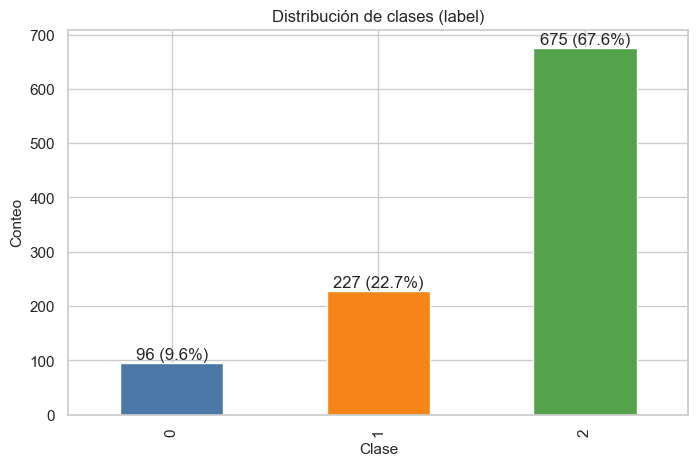

In [4]:
counts = df['label'].value_counts().sort_index()
total = counts.sum()
ax = counts.plot(kind='bar', color=['#4C78A8','#F58518','#54A24B'])
ax.set_title('Distribución de clases (label)')
ax.set_xlabel('Clase')
ax.set_ylabel('Conteo')
for i, v in enumerate(counts.values):
    ax.text(i, v + max(counts.values)*0.01, f"{v} ({v/total:.1%})", ha='center')
plt.show()

#### Distribución de z
* Podemos notar que la mayoría de los valores de `z` son bajos (entre 0 y 0.3)
* La clase 1 se concentra en un `z` más bajo, la 2 tiene valores un poco más a la derecha y está más dispersa y la 0 es intermedia.
* Existe demasiado solapamiento.

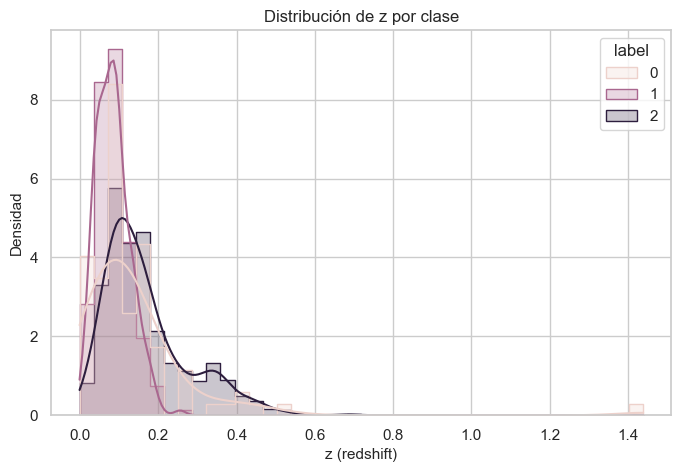

In [5]:
sns.histplot(data=df, x='z', hue='label', bins=40, kde=True, stat='density', common_norm=False, element='step')
plt.title('Distribución de z por clase')
plt.xlabel('z (redshift)')
plt.ylabel('Densidad')
plt.show()

#### Boxplot de magnitudes
* Con este gráfico podemos notar que la clase 2 tiene magnitudes más altas, mientras la clase 1 es la más baja y la 0 la intermedia.
* `u` y `g` tienen las diferencias más notorias, mientras que en `r`, `i` y `z` las brechas son menores.
* Ya que las clases están muy solapadas, un índice de color podría ayudar a describir mejor

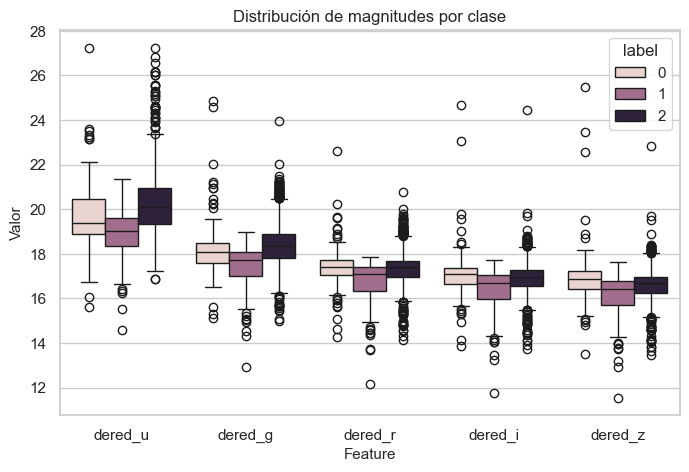

In [6]:
brillo = ['dered_u','dered_g','dered_r', 'dered_i', 'dered_z']

df_melt = df.melt(id_vars='label', value_vars=brillo, var_name='feature', value_name='value')
sns.boxplot(data=df_melt, x='feature', y='value', hue='label')
plt.title('Distribución de magnitudes por clase')
plt.xlabel('Feature')
plt.ylabel('Valor')
plt.legend(title='label')
plt.show()

#### Gráfico de correlaciones
> Nota: Incluye índices de color (u−g, g−r, r−i, i−z) construidos a partir de magnitudes dered_*, junto a `z`, `mRrCc_r` y `score`. Esto ayuda a ver relaciones entre colores y rasgos fotométricos/morfológicos.
* Magnitudes `dered_*` muy correlacionadas entre sí (entre 0.84 a 0.95) → son redundantes; conviene usar menos o reemplazarlas por índices de color.
* `z` se asocia con el color: `g_r` (~0.73) y `u_g` (~0.56). A mayor `z`, el objeto luce más rojo → los colores son informativos.
* Los índices de color están menos correlacionados entre sí que las magnitudes crudas, aportando señal complementaria (`g_r` el más fuerte).
* `mRrCc_r` casi desacoplado (correlaciones cercanas a 0) → agrega información morfológica independiente de los colores/magnitudes.
* `score` muestra correlaciones bajas a moderadas (p. ej., con `r_i` ~0.44); puede ayudar pero conviene vigilar sesgos.

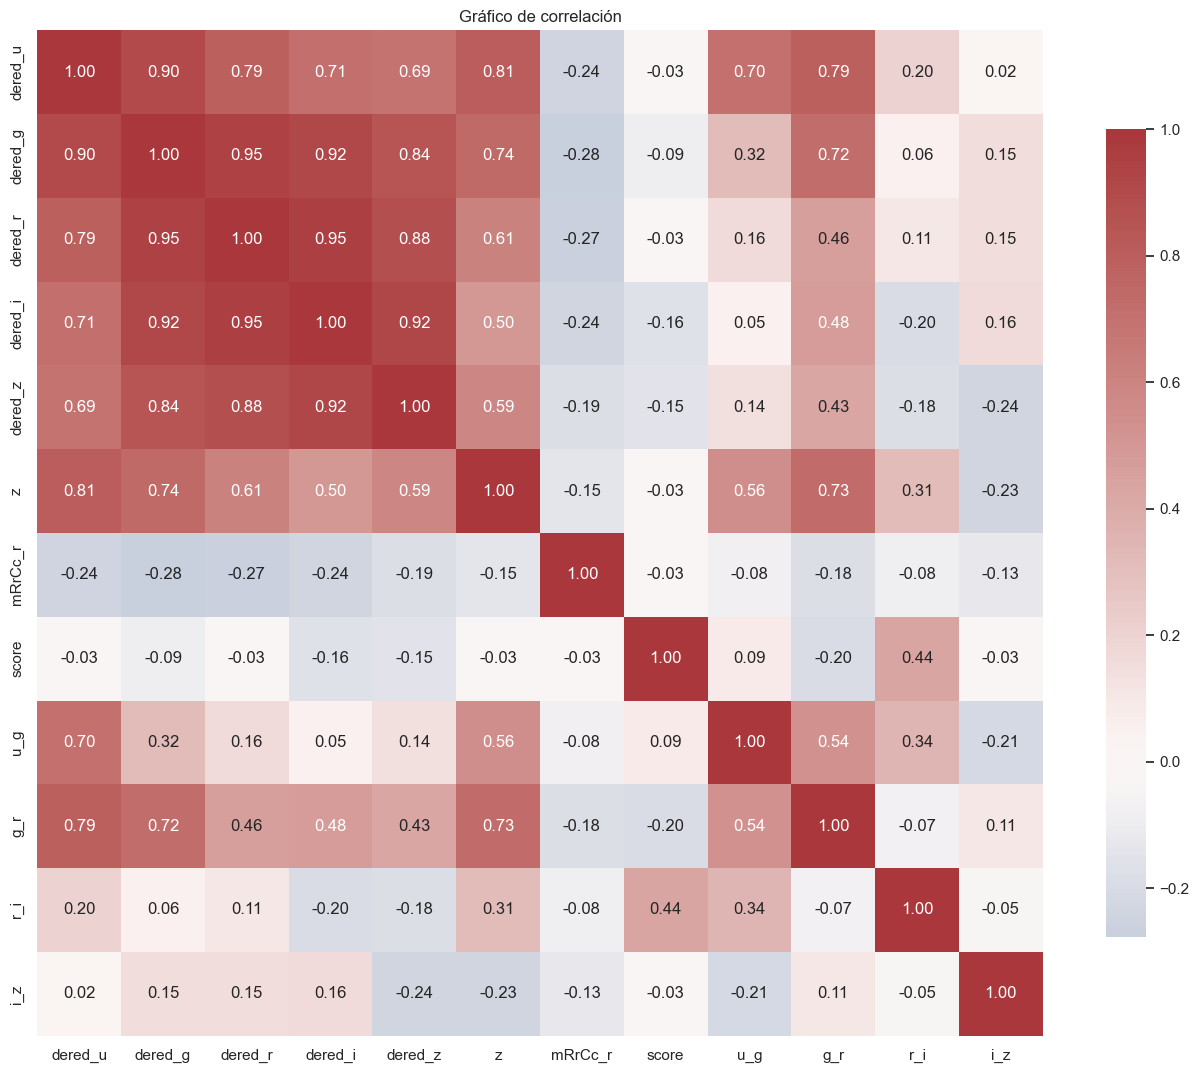

In [7]:
df['u_g'] = df['dered_u'] - df['dered_g']
df['g_r'] = df['dered_g'] - df['dered_r']
df['r_i'] = df['dered_r'] - df['dered_i']
df['i_z'] = df['dered_i'] - df['dered_z']

base_feats = ['dered_u','dered_g','dered_r','dered_i','dered_z','z','mRrCc_r','score']
color_feats = ['u_g','g_r','r_i','i_z']
cand = base_feats + color_feats

corr = df[cand].corr(numeric_only=True)
plt.figure(figsize=(1.1*len(cand), 0.9*len(cand)))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0, square=True, cbar_kws={'shrink':0.8})
plt.title('Gráfico de correlación')
plt.tight_layout()
plt.show()

---
---
# Modelo

Como ya analizamos en el apartado de datos, hay columnas innecesarias

In [8]:
# Columnas de filtrado, innecesarias para el análisis
DROP_COLS = [
    "mode", "resolveStatus", "sciencePrimary", "objID", "ID",
    "legacyPrimary", "seguePrimary", "segue1Primary", "segue2Primary",
    "bossPrimary", "sdssPrimary"
]

# Columnas con fuga de información
LEAK_COLS = [
    "p_el", "p_cs"
]

# Columnas de la respuesta
ANSWER_COLS = [
    "ID", "label"
]

In [9]:
df_train = df.copy()
df_test = pd.read_csv('data/GZ_mini_challenge_test.csv')

df_train.drop(columns=DROP_COLS + LEAK_COLS, inplace=True)
df_train = df_train[df_train['label'] != 3]

Preparamos X e y

In [10]:
y = df_train['label'].astype(int)
X = df_train.drop(columns=['label'])

print("Distribución original de clases:", np.bincount(y))

Distribución original de clases: [ 96 227 675]


#### Modo Testeo
Aquí particionamos el dataframe de entrenamiento para obtener resultados preliminares

In [11]:
x_train, x_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print("Shapes (train/val/test):", x_train.shape, x_val.shape, x_test.shape)

Shapes (train/val/test): (698, 80) (150, 80) (150, 80)


Estandarizamos:

In [12]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

Aplicamos SMOTE para balancear las clases

In [13]:
sm = SMOTE(random_state=42, k_neighbors=3)
res_sm = sm.fit_resample(x_train_scaled, y_train)
if isinstance(res_sm, tuple) and len(res_sm) >= 2:
    x_train_bal, y_train_bal = res_sm[0], res_sm[1]
else:
    x_train_bal, y_train_bal = cast(tuple, res_sm)  # type: ignore
print("Dataset balanceado (train SMOTE):", np.bincount(y_train_bal))

Dataset balanceado (train SMOTE): [472 472 472]


Elegimos las mejores features con RFE

In [14]:
n_features_to_select = min(20, x_train_bal.shape[1])
rf_for_rfe = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rfe = RFE(rf_for_rfe, n_features_to_select=n_features_to_select)
x_train_sel = rfe.fit_transform(np.asarray(x_train_bal), np.asarray(y_train_bal))
x_val_sel = rfe.transform(x_val_scaled)
x_test_sel = rfe.transform(x_test_scaled)
print(f"RFE seleccionó {x_train_sel.shape[1]} características.")

RFE seleccionó 20 características.


#### Modo Predictorio
Aquí predecimos en el dataframe de testing

In [15]:
feature_cols = X.columns.tolist()
train_means = X.mean(numeric_only=True)

Estandarizamos:

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Aplicamos SMOTE para balancear clases

In [17]:
sm = SMOTE(random_state=42, k_neighbors=3)
res_ext = sm.fit_resample(X_scaled, y)
if isinstance(res_ext, tuple) and len(res_ext) >= 2:
    X_bal, y_bal = res_ext[0], res_ext[1]
else:
    X_bal, y_bal = cast(tuple, res_ext)  # type: ignore
print("Train balanceado (SMOTE):", np.bincount(y_bal))

Train balanceado (SMOTE): [675 675 675]


Elegimos features con RFE

In [18]:
n_features_to_select = min(20, X_bal.shape[1])
rf_for_rfe = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rfe = RFE(rf_for_rfe, n_features_to_select=n_features_to_select)
X_sel = rfe.fit_transform(np.asarray(X_bal), np.asarray(y_bal))

#### Entrenamos modelos

Empezamos con Random Forest

In [19]:
rf = RandomForestClassifier(
    n_estimators=300, class_weight='balanced_subsample', random_state=42, n_jobs=-1)
rf.fit(x_train_sel, y_train_bal)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Seguimos con XGBoost

In [20]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=300, learning_rate=0.08, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42, n_jobs=-1)
xgb_clf.fit(x_train_sel, y_train_bal)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


Y por último logistic regression

In [21]:
lr = LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs')
lr.fit(x_train_sel, y_train_bal)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


Luego, agrupamos todos los modelos anteriores en un ensamble

In [22]:
estimators: List[Tuple[str, BaseEstimator]] = [('rf', rf)]
estimators.append(('xgb', xgb_clf))
estimators.append(('lr', lr))
ensemble = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
ensemble.fit(x_train_sel, y_train_bal)

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1


# Evaluación

#### Modo Testeo

Calcula predicciones en validación (`y_val_pred`) y reporta métricas: classification_report y F1 ponderado para el split de validación.

In [23]:
y_val_pred = ensemble.predict(x_val_sel)
val_f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
print("\nValidation classification report:")
print(classification_report(y_val, y_val_pred, digits=4))
print("Validation F1 weighted:", val_f1_weighted)


Validation classification report:
              precision    recall  f1-score   support

           0     0.2857    0.2857    0.2857        14
           1     0.6875    0.6471    0.6667        34
           2     0.8654    0.8824    0.8738       102

    accuracy                         0.7733       150
   macro avg     0.6129    0.6050    0.6087       150
weighted avg     0.7710    0.7733    0.7720       150

Validation F1 weighted: 0.771952535059331


Evalúa el desempeño en el split de test interno: imprime classification_report, F1 ponderado y la matriz de confusión.

In [24]:
y_test_pred = ensemble.predict(x_test_sel)
print("\nTest classification report:")
print(classification_report(y_test, y_test_pred, digits=4))
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
print("Test F1 weighted:", test_f1_weighted)
print("Confusion matrix (test):\n", confusion_matrix(y_test, y_test_pred))


Test classification report:
              precision    recall  f1-score   support

           0     0.1538    0.1333    0.1429        15
           1     0.7188    0.6765    0.6970        34
           2     0.8667    0.9010    0.8835       101

    accuracy                         0.7733       150
   macro avg     0.5798    0.5703    0.5744       150
weighted avg     0.7619    0.7733    0.7672       150

Test F1 weighted: 0.7671522436570981
Confusion matrix (test):
 [[ 2  3 10]
 [ 7 23  4]
 [ 4  6 91]]


Realiza una validación cruzada 5-fold sobre el conjunto de entrenamiento (sin tocar test) y muestra media ± desviación del F1 ponderado.

In [25]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
x_train_scaled_orig = scaler.transform(x_train)
x_train_sel_orig = rfe.transform(x_train_scaled_orig)
try:
    cv_scores = cross_val_score(ensemble, x_train_sel_orig, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)
    print("CV F1_weighted (train, 5-fold): mean=%.4f std=%.4f" % (cv_scores.mean(), cv_scores.std()))
except Exception as e:
    print("No se pudo ejecutar cross_val_score en ensemble:", e)

CV F1_weighted (train, 5-fold): mean=0.7772 std=0.0303


Resume las métricas de validación y test

In [26]:
print("\n--- Resumen final ---")
print(f"Validation F1 weighted: {val_f1_weighted:.4f}")
print(f"Test F1 weighted: {test_f1_weighted:.4f}")


--- Resumen final ---
Validation F1 weighted: 0.7720
Test F1 weighted: 0.7672


#### Modo Predictorio

* Cross-Validation: 
Para estimar el desempeño sin usar el set de test, calculamos un F1-weighted out-of-fold con 5 folds (StratifiedKFold). En cada fold se ajusta el `StandardScaler`, se aplica `SMOTE` solo al train, se seleccionan features con `RFE` y se entrena el ensamble; luego se evalúa en el fold de validación.
> Nota: Opcional, solo para darme una idea de los resultados

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_scores = []
fold = 0
for tr_idx, va_idx in cv.split(X, y):
    fold += 1
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    scaler_cv = StandardScaler()
    X_tr_sc = scaler_cv.fit_transform(X_tr)
    X_va_sc = scaler_cv.transform(X_va)

    sm_cv = SMOTE(random_state=42, k_neighbors=3)

    res_sm_cv = sm_cv.fit_resample(X_tr_sc, y_tr)
    if isinstance(res_sm_cv, tuple) and len(res_sm_cv) >= 2:
        X_tr_bal_cv, y_tr_bal_cv = res_sm_cv[0], res_sm_cv[1]
    else:
        X_tr_bal_cv, y_tr_bal_cv = cast(tuple, res_sm_cv)  # type: ignore

    n_sel = min(20, X_tr_bal_cv.shape[1])
    rfe_cv = RFE(RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
                 n_features_to_select=n_sel)
    X_tr_sel_cv = rfe_cv.fit_transform(X_tr_bal_cv, y_tr_bal_cv)
    X_va_sel_cv = rfe_cv.transform(X_va_sc)

    rf_cv = RandomForestClassifier(n_estimators=300, class_weight='balanced_subsample', random_state=42, n_jobs=-1)
    xgb_cv = xgb.XGBClassifier(
        n_estimators=300, learning_rate=0.08, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric='mlogloss',
        random_state=42, n_jobs=-1
    )
    lr_cv = LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs')

    ensemble_cv = VotingClassifier(estimators=[('rf', rf_cv), ('xgb', xgb_cv), ('lr', lr_cv)], voting='soft', n_jobs=-1)
    ensemble_cv.fit(X_tr_sel_cv, y_tr_bal_cv)

    y_va_pred_cv = ensemble_cv.predict(X_va_sel_cv)
    score = f1_score(y_va, y_va_pred_cv, average='weighted')
    oof_scores.append(score)
    print(f"Fold {fold}: F1_weighted = {score:.4f}")

cv_f1_mean = float(np.mean(oof_scores))
cv_f1_std = float(np.std(oof_scores))
print("\nCV F1_weighted (OOF, 5-fold): mean=%.4f std=%.4f" % (cv_f1_mean, cv_f1_std))

Fold 1: F1_weighted = 0.7646
Fold 2: F1_weighted = 0.7939
Fold 2: F1_weighted = 0.7939


Aplicar mismo preprocesamiento al Dataframe de testing

In [ ]:
X_test = df_test.drop(columns=DROP_COLS + LEAK_COLS, errors='ignore').copy()
X_test = X_test.reindex(columns=feature_cols)
X_test = X_test.fillna(train_means)

X_test_scaled = scaler.transform(X_test)
X_test_sel = rfe.transform(X_test_scaled)

Guardamos en data/predict.csv

In [ ]:
y_pred_test = np.array(ensemble.predict(X_test_sel), dtype=int)
df_pred = pd.DataFrame({
    'ID': df_test['ID'].astype(int).values,
    'label': y_pred_test
})[ANSWER_COLS]

out_path = "data/predict.csv"
df_pred.to_csv(out_path, index=False)
print(f"Predicciones guardadas en {out_path}.")

Predicciones guardadas en data/predict.csv.
